In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import fit_library as ft


%matplotlib nbagg
%load_ext autoreload
%autoreload 2

In [2]:
def TDC_fit(data, canal, tac, guess=[-82,360,0,280]):
    chisq = 100
    amplitude = guess[0]
    period    = guess[1]
    shift     = guess[2]
    offset    = guess[3]
    
    while((chisq > 10) & (shift < 360)):
        datos = data[(data.tac==tac)&(data.channel==canal)]
        Q_fit = ft.fitting_nohist()
        coeff  = [amplitude,period,shift,offset]
        #bounds = [[-200,350,   0,   0],
        #          [   0,360,  50, 350]]
        Q_fit(datos.eval("mean"),datos.phase,ft.sawtooth,
          [amplitude,period,shift,offset])
        chisq = np.sum(((datos.eval("mean")-Q_fit.evaluate(datos.phase))/datos.sigma)**2)
        print("Channel = %d / CHISQR = %f" % (canal,chisq))
        #print(Q_fit.coeff)
        shift = shift + 10

    #plt.figure()
    #plt.plot(datos.phase,Q_fit.evaluate(datos.phase),'b-',label="Fit")
    #plt.errorbar(datos.phase,datos.eval("mean"), datos.sigma,
    #             fmt='.',color='red',label="Data")
    #plt.xlabel("PHASE")
    #plt.ylabel("TFINE")
    #plt.legend()
    return chisq, Q_fit

In [3]:
filename = "/home/viherbos/DATA_daq/tfine_calibration.h5"
data = pd.read_hdf(filename)

In [4]:
tac=0
A=[TDC_fit(data, i, tac=tac) for i in range(64)]

/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Channel = 0 / CHISQR = 2.350217
Channel = 1 / CHISQR = 5.441671
Channel = 2 / CHISQR = 7.273677


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Channel = 3 / CHISQR = 7.057946
Channel = 4 / CHISQR = 3.457480
Channel = 5 / CHISQR = 2.035639
Channel = 6 / CHISQR = 2.707462
Channel = 7 / CHISQR = 4.615688


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Channel = 8 / CHISQR = 5.288032
Channel = 9 / CHISQR = 1.906323


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWar

Channel = 10 / CHISQR = 7.851385
Channel = 11 / CHISQR = 3.534196
Channel = 12 / CHISQR = 6.537088
Channel = 13 / CHISQR = 3.396298
Channel = 14 / CHISQR = 6.516266
Channel = 15 / CHISQR = 8.105944
Channel = 16 / CHISQR = 8.872659
Channel = 17 / CHISQR = 7.571386


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWar

Channel = 18 / CHISQR = 5.994295
Channel = 19 / CHISQR = 9.496953
Channel = 20 / CHISQR = 7.494349
Channel = 21 / CHISQR = 5.947223
Channel = 22 / CHISQR = 8.792784
Channel = 23 / CHISQR = 6.358235
Channel = 24 / CHISQR = 3.845987


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Channel = 25 / CHISQR = 7.573677
Channel = 26 / CHISQR = 7.768469


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Channel = 27 / CHISQR = 6.557864
Channel = 28 / CHISQR = 8.941820
Channel = 29 / CHISQR = 7.794369
Channel = 30 / CHISQR = 7.036497


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Channel = 31 / CHISQR = 8.071699
Channel = 32 / CHISQR = 6.144315
Channel = 33 / CHISQR = 7.513982
Channel = 34 / CHISQR = 5923.605359
Channel = 34 / CHISQR = 2573.500703
Channel = 34 / CHISQR = 3.601901
Channel = 35 / CHISQR = 5926.147053
Channel = 35 / CHISQR = 1932.661368
Channel = 35 / CHISQR = 3.739456
Channel = 36 / CHISQR = 5489.936419
Channel = 36 / CHISQR = 6233.922522
Channel = 36 / CHISQR = 22.138557
Channel = 36 / CHISQR = 4.493094
Channel = 37 / CHISQR = 5805.912815
Channel = 37 / CHISQR = 2150.983235
Channel = 37 / CHISQR = 3.166395

/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)



Channel = 38 / CHISQR = 5764.117201
Channel = 38 / CHISQR = 565.516019
Channel = 38 / CHISQR = 6505.486799
Channel = 38 / CHISQR = 4.344504
Channel = 39 / CHISQR = 6157.070676
Channel = 39 / CHISQR = 1594.775571
Channel = 39 / CHISQR = 3.751467


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Channel = 40 / CHISQR = 5831.606133
Channel = 40 / CHISQR = 3.549761
Channel = 41 / CHISQR = 5563.511631
Channel = 41 / CHISQR = 5989.596819
Channel = 41 / CHISQR = 54.212179
Channel = 41 / CHISQR = 6.288212
Channel = 42 / CHISQR = 5308.155024
Channel = 42 / CHISQR = 863.873627
Channel = 42 / CHISQR = 7253.990756
Channel = 42 / CHISQR = 2.983255
Channel = 43 / CHISQR = 6169.333833
Channel = 43 / CHISQR = 2649.444434


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Channel = 43 / CHISQR = 2.808536
Channel = 44 / CHISQR = 6169.707745
Channel = 44 / CHISQR = 6389.598389


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Channel = 44 / CHISQR = 121.183178
Channel = 44 / CHISQR = 7.866210
Channel = 45 / CHISQR = 5505.516383
Channel = 45 / CHISQR = 2221.622374


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Channel = 45 / CHISQR = 2.827784
Channel = 46 / CHISQR = 5564.586009
Channel = 46 / CHISQR = 3379.977065
Channel = 46 / CHISQR = 10.922774
Channel = 46 / CHISQR = 3.751006
Channel = 47 / CHISQR = 5676.287925
Channel = 47 / CHISQR = 1739.343575
Channel = 47 / CHISQR = 2.766776
Channel = 48 / CHISQR = 5715.621000
Channel = 48 / CHISQR = 953.162175


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Channel = 48 / CHISQR = 2507.816194
Channel = 48 / CHISQR = 3.151668
Channel = 49 / CHISQR = 5623.524720


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Channel = 49 / CHISQR = 696.800743
Channel = 49 / CHISQR = 1961.313715
Channel = 49 / CHISQR = 3.716192
Channel = 50 / CHISQR = 5284.846519


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Channel = 50 / CHISQR = 2595.002905
Channel = 50 / CHISQR = 8685.839561
Channel = 50 / CHISQR = 4.680073


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Channel = 51 / CHISQR = 7520.038460
Channel = 51 / CHISQR = 2.941683
Channel = 52 / CHISQR = 7728.173784
Channel = 52 / CHISQR = 2.327633
Channel = 53 / CHISQR = 7937.198858
Channel = 53 / CHISQR = 3.008675
Channel = 54 / CHISQR = 8109.114517
Channel = 54 / CHISQR = 6918.877335
Channel = 54 / CHISQR = 2.374981
Channel = 55 / CHISQR = 8554.861931
Channel = 55 / CHISQR = 3.793343
Channel = 56 / CHISQR = 7658.357657
Channel = 56 / CHISQR = 7658.357976


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Channel = 56 / CHISQR = 123.858549
Channel = 56 / CHISQR = 6317.566024
Channel = 56 / CHISQR = 7658.357849
Channel = 56 / CHISQR = 3.002697
Channel = 57 / CHISQR = 7054.823984


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Channel = 57 / CHISQR = 2.292928
Channel = 58 / CHISQR = 8105.167588
Channel = 58 / CHISQR = 6949.235901
Channel = 58 / CHISQR = 2.268057
Channel = 59 / CHISQR = 8236.525806
Channel = 59 / CHISQR = 6900.232433
Channel = 59 / CHISQR = 2.901321
Channel = 60 / CHISQR = 8624.015089
Channel = 60 / CHISQR = 3.133715
Channel = 61 / CHISQR = 4855.917026
Channel = 61 / CHISQR = 2514.659318
Channel = 61 / CHISQR = 7407.283660


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Channel = 61 / CHISQR = 2.548043
Channel = 62 / CHISQR = 5341.848533
Channel = 62 / CHISQR = 6722.564143
Channel = 62 / CHISQR = 7588.280406
Channel = 62 / CHISQR = 3.156870
Channel = 63 / CHISQR = 5477.901462


/home/viherbos/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Channel = 63 / CHISQR = 962.534391
Channel = 63 / CHISQR = 2506.542958
Channel = 63 / CHISQR = 2.925085


<IPython.core.display.Javascript object>


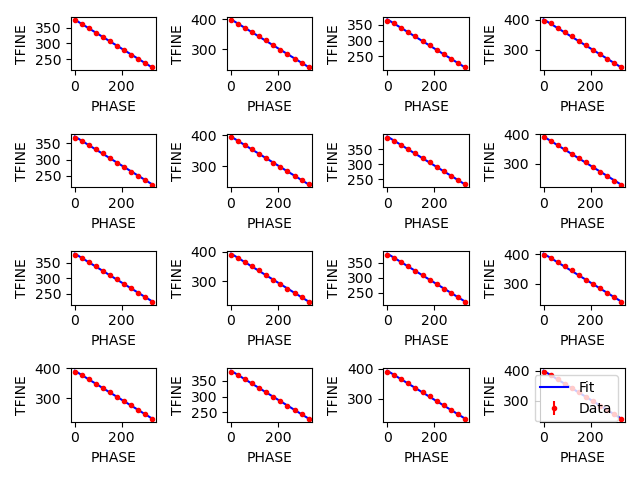

In [5]:
tac=0
fig, axs = plt.subplots(4, 4)
x=y=0
for i in range(0,4):
    for j in range(0,4):
        datos = data[(data.tac==tac)&(data.channel==i*8+j)]
        axs[y,x].plot(datos.phase,A[i*8+j][1].evaluate(datos.phase),'b-',label="Fit")
        axs[y,x].errorbar(datos.phase,datos.eval("mean"), datos.sigma,
                          fmt='.',color='red',label="Data")
        axs[y,x].set_xlabel("PHASE")
        axs[y,x].set_ylabel("TFINE")
        x=x+1
    y=y+1
    x=0
        
fig.tight_layout()
plt.legend()

<IPython.core.display.Javascript object>


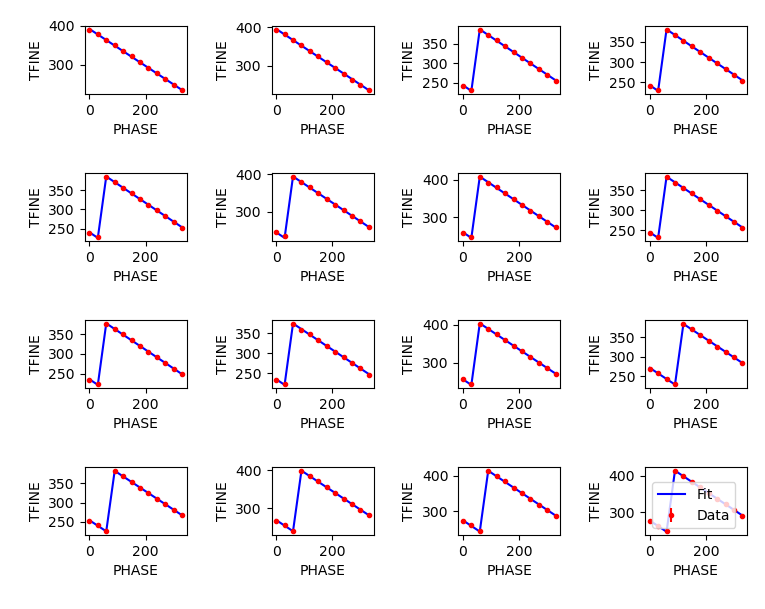

In [6]:
tac=0
fig, axs = plt.subplots(4, 4)
x=y=0
for i in range(4,8):
    for j in range(0,4):
        datos = data[(data.tac==tac)&(data.channel==i*8+j)]
        axs[y,x].plot(datos.phase,A[i*8+j][1].evaluate(datos.phase),'b-',label="Fit")
        axs[y,x].errorbar(datos.phase,datos.eval("mean"), datos.sigma,
                          fmt='.',color='red',label="Data")
        axs[y,x].set_xlabel("PHASE")
        axs[y,x].set_ylabel("TFINE")
        x=x+1
    y=y+1
    x=0
        
fig.tight_layout()
plt.legend()

<IPython.core.display.Javascript object>


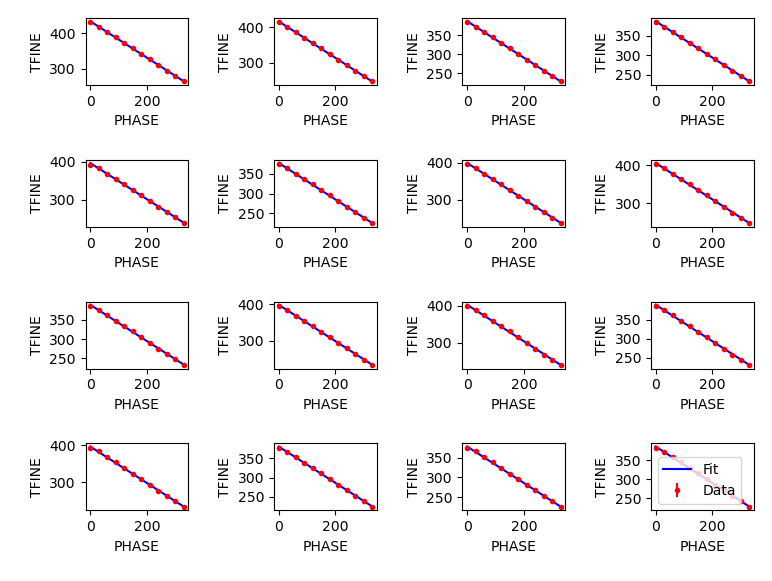

In [7]:
tac=0
fig, axs = plt.subplots(4, 4)
x=y=0
for i in range(0,4):
    for j in range(4,8):
        datos = data[(data.tac==tac)&(data.channel==i*8+j)]
        axs[y,x].plot(datos.phase,A[i*8+j][1].evaluate(datos.phase),'b-',label="Fit")
        axs[y,x].errorbar(datos.phase,datos.eval("mean"), datos.sigma,
                          fmt='.',color='red',label="Data")
        axs[y,x].set_xlabel("PHASE")
        axs[y,x].set_ylabel("TFINE")
        x=x+1
    y=y+1
    x=0
        
fig.tight_layout()
plt.legend()

<IPython.core.display.Javascript object>


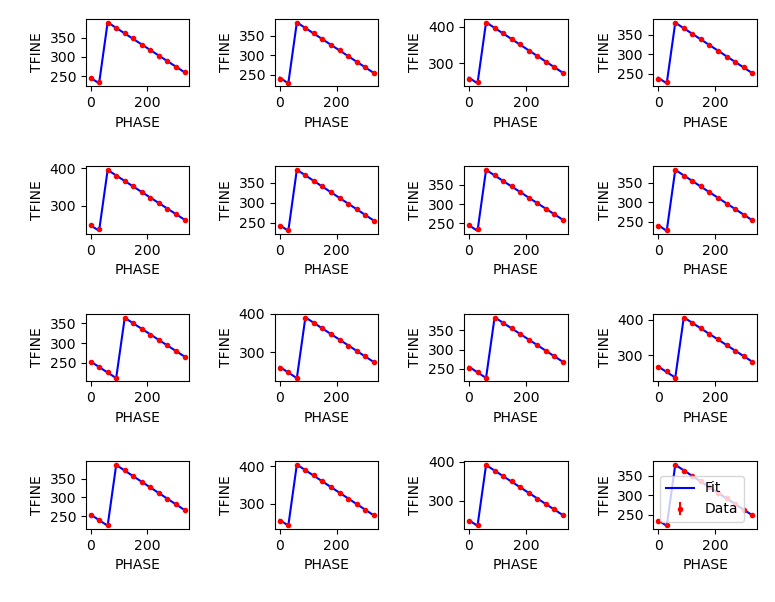

In [8]:
tac=0
fig, axs = plt.subplots(4, 4)
x=y=0
for i in range(4,8):
    for j in range(4,8):
        datos = data[(data.tac==tac)&(data.channel==i*8+j)]
        axs[y,x].plot(datos.phase,A[i*8+j][1].evaluate(datos.phase),'b-',label="Fit")
        axs[y,x].errorbar(datos.phase,datos.eval("mean"), datos.sigma,
                          fmt='.',color='red',label="Data")
        axs[y,x].set_xlabel("PHASE")
        axs[y,x].set_ylabel("TFINE")
        x=x+1
    y=y+1
    x=0
        
fig.tight_layout()
plt.legend()

In [9]:
CHISQR=[A[i][0] for i in range(64)]

In [10]:
print(np.max(CHISQR))

9.496953214885453


<IPython.core.display.Javascript object>


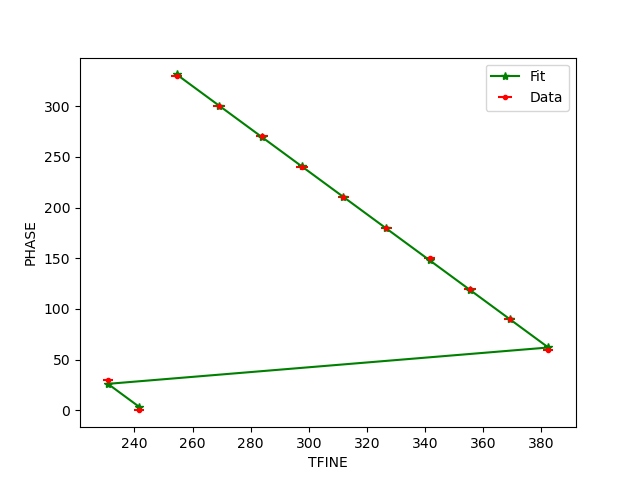

In [11]:
plt.figure()
canal = 45
datos = data[(data.tac==tac)&(data.channel==canal)]

plt.errorbar(datos.eval("mean"),datos.phase, xerr=datos.sigma,
             fmt='.',color='red',label="Data")
plt.ylabel("PHASE")
plt.xlabel("TFINE")
inverse = ft.sawtooth_inv(datos.eval("mean"),*A[canal][1].coeff)

plt.plot(datos.eval("mean"),inverse,'g-*',label="Fit")
plt.legend()